In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange
from joblib import Parallel, delayed
from import_fun import compute_mle_jit

#### HH模型

In [3]:
@njit
def HH_delay(x, x_tau, t, g_e, degree, lam):
    res = np.zeros_like(x)
    # 常数参数
    C_m = 1.0    # 膜电容，单位 uF/cm^2
    g_Na = 120.0 # 钠离子通道最大电导，单位 mS/cm^2
    g_K = 36.0   # 钾离子通道最大电导，单位 mS/cm^2
    g_L = 0.3    # 泄漏通道电导，单位 mS/cm^2
    E_Na = 50.0  # 钠离子平衡电位，单位 mV
    E_K = -77.0  # 钾离子平衡电位，单位 mV
    E_L = -54.4  # 泄漏通道平衡电位，单位 mV
    I_ext = 20   # 外部电流，单位 uA/cm^2
    # degree = degree   # 节点的入度
    # g_e = g_e    # 耦合强度

    # 状态变量
    V, m, h, n = x
    V_tau, m_tau, h_tau, n_tau = x_tau

   # 计算 α 和 β 函数
    epsilon = 0  # 防止除零

    alpha_n = 0.01 * (V + 55) / (1 - np.exp(-(V + 55) / 10) + epsilon)
    beta_n = 0.125 * np.exp(-(V + 65) / 80)

    alpha_m = 0.1 * (V + 40) / (1 - np.exp(-(V + 40) / 10) + epsilon)
    beta_m = 4 * np.exp(-(V + 65) / 18)

    alpha_h = 0.07 * np.exp(-(V + 65) / 20)
    beta_h = 1 / (1 + np.exp(-(V + 35) / 10) + epsilon)

    # 门控变量的导数
    dmdt = alpha_m * (1 - m) - beta_m * m
    dhdt = alpha_h * (1 - h) - beta_h * h
    dndt = alpha_n * (1 - n) - beta_n * n

    # 离子电流
    I_Na = g_Na * m**3 * h * (V - E_Na)
    I_K = g_K * n**4 * (V - E_K)
    I_L = g_L * (V - E_L)

    # 膜电位的导数
    dVdt = (I_ext - I_Na - I_K - I_L) / C_m

    # 输出结果
    res[0] = dVdt + g_e * degree * (V_tau - V) / C_m
    res[1] = dmdt
    res[2] = dhdt
    res[3] = dndt

    return res

@njit
def jac_delay(x, x_tau, t, g_e, degree, lam):
    res = np.zeros((x.shape[0], x.shape[0]))
    # 常数参数
    C_m = 1.0    # 膜电容，单位 uF/cm^2
    g_Na = 120.0 # 钠离子通道最大电导，单位 mS/cm^2
    g_K = 36.0   # 钾离子通道最大电导，单位 mS/cm^2
    g_L = 0.3    # 泄漏通道电导，单位 mS/cm^2
    E_Na = 50.0  # 钠离子平衡电位，单位 mV
    E_K = -77.0  # 钾离子平衡电位，单位 mV
    E_L = -54.4  # 泄漏通道平衡电位，单位 mV
    I_ext = 20   # 外部电流，单位 uA/cm^2
    # degree = degree   # 节点的入度
    # g_e = g_e    # 耦合强度
    # lam = lam      # 特征值

    # 状态变量
    V, m, h, n = x
    V_tau, m_tau, h_tau, n_tau = x_tau

    # 计算 α 和 β 函数及其导数
    epsilon = 0  # 防止除零

    # α_n 和 β_n 及其对 V 的导数
    denom_n = 1 - np.exp(-(V + 55) / 10) + epsilon
    alpha_n = 0.01 * (V + 55) / denom_n
    dalpha_n_dV = ( (0.01 * denom_n) - 0.001 * (V + 55) * np.exp(-(V + 55) / 10) ) / (denom_n**2)
    beta_n = 0.125 * np.exp(-(V + 65) / 80)
    dbeta_n_dV = -0.125 * np.exp(-(V + 65) / 80) / 80

    # α_m 和 β_m 及其对 V 的导数
    denom_m = 1 - np.exp(-(V + 40) / 10) + epsilon
    alpha_m = 0.1 * (V + 40) / denom_m
    dalpha_m_dV = ( (0.1 * denom_m) - 0.01 * (V + 40) * np.exp(-(V + 40) / 10) ) / (denom_m**2)
    beta_m = 4.0 * np.exp(-(V + 65) / 18)
    dbeta_m_dV = -4.0 * np.exp(-(V + 65) / 18) / 18

    # α_h 和 β_h 及其对 V 的导数
    alpha_h = 0.07 * np.exp(-(V + 65) / 20)
    dalpha_h_dV = -0.07 * np.exp(-(V + 65) / 20) / 20
    beta_h = 1.0 / (1 + np.exp(-(V + 35) / 10) + epsilon)
    dbeta_h_dV = (np.exp(-(V + 35) / 10) / 10) / ((1 + np.exp(-(V + 35) / 10) + epsilon)**2)

    # 计算离子电流及其对状态变量的导数
    I_Na = g_Na * m**3 * h * (V - E_Na)
    I_K = g_K * n**4 * (V - E_K)
    I_L = g_L * (V - E_L)

    # 对 V 的偏导数
    dI_Na_dV = g_Na * m**3 * h
    dI_K_dV = g_K * n**4
    dI_L_dV = g_L

    # 对 m 的偏导数
    dI_Na_dm = g_Na * h * (V - E_Na) * 3 * (m**2)

    # 对 h 的偏导数
    dI_Na_dh = g_Na * (m**3) * (V - E_Na)

    # 对 n 的偏导数
    dI_K_dn = g_K * (V - E_K) * 4 * (n**3)

    # 雅可比矩阵元素计算
    # 第一行，对应 dV/dt
    res[0, 0] = (-dI_Na_dV - dI_K_dV - dI_L_dV ) / C_m - g_e * degree / C_m
    res[0, 1] = (-dI_Na_dm) / C_m
    res[0, 2] = (-dI_Na_dh) / C_m
    res[0, 3] = (-dI_K_dn) / C_m

    # 第二行，对应 dm/dt
    res[1, 0] = dalpha_m_dV * (1 - m) - dbeta_m_dV * m
    res[1, 1] = -alpha_m - beta_m
    res[1, 2] = 0
    res[1, 3] = 0

    # 第三行，对应 dh/dt
    res[2, 0] = dalpha_h_dV * (1 - h) - dbeta_h_dV * h
    res[2, 1] = 0
    res[2, 2] = -alpha_h - beta_h
    res[2, 3] = 0

    # 第四行，对应 dn/dt
    res[3, 0] = dalpha_n_dV * (1 - n) - dbeta_n_dV * n
    res[3, 1] = 0
    res[3, 2] = 0
    res[3, 3] = -alpha_n - beta_n

    df_dx_tau = np.zeros((x.shape[0], x.shape[0]))
    df_dx_tau[0, 0] =  (g_e * degree - g_e * lam) / C_m

    return res, df_dx_tau

In [4]:
x0 = np.zeros(4)
t0 = 0.
dt = 1e-2
T_init = int(1e5)
T_cal = int(1e6)
# tau = 0.
tau_list = np.arange(0, 35, .1)
n = len(tau_list)
degree = 1
g_e = 0.01
lam = degree+1
# lam = 0

In [5]:
mLCE_values = Parallel(n_jobs=-1)(
    delayed(compute_mle_jit)(x0, HH_delay, jac_delay, tau, T_init, T_cal, dt, g_e, degree, lam) 
    for tau in tau_list
    )

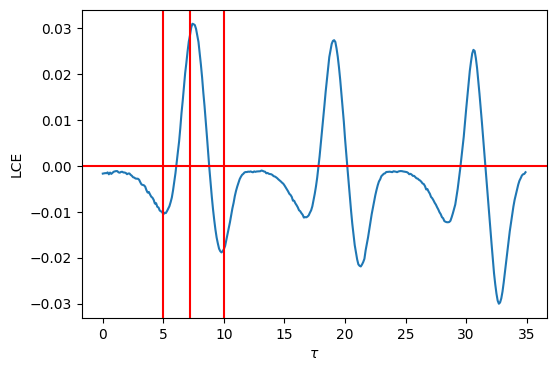

In [6]:
# Plot of LCE
plt.figure(figsize=(6, 4))
plt.plot(tau_list, mLCE_values)
# plt.xlim(10, 15)
plt.axhline(y=0, c="r")
plt.axvline(x=5, c="r")
plt.axvline(x=7.2, c="r")
plt.axvline(x=10, c="r")
plt.ylabel("LCE")
plt.xlabel(r"$\tau$")
plt.show()